# Sampling from Known and Unknown Measures

In [1]:
from qmcpy import *
from numpy import *
from scipy import stats
from matplotlib import pyplot

## Inverse CDF Sampling

### Exponential
$$y \sim exp(\lambda) \qquad \text{pdf y } f(x) = \lambda e^{-\lambda x} \\
\text{cdf y } F(x) = 1-e^{-\lambda x} \qquad \text{inverse cdf } F^{-1}(x) = \frac{-log(1-x)}{\lambda} \\
\therefore y \sim \frac{-log(1-u)}{\lambda} \text{ for } u \sim U_d(0,1)$$

In [2]:
# constants
lambda_ = 1.5
exp_pdf = lambda x,l=lambda_: l*exp(-l*x)
exp_inverse_cdf = lambda u,l=lambda_: -log(1-u)/l

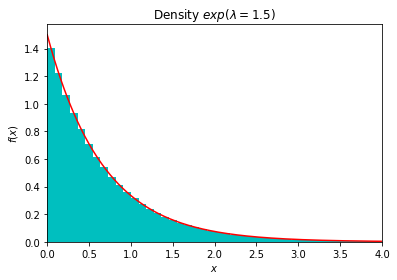

In [3]:
# 1 dimension
exponential_measure = InverseCDFSampling(
    distribution_mimicking_uniform = Lattice(dimension=1,seed=7),
    inverse_cdf_fun = exp_inverse_cdf)
exp_samples = exponential_measure.gen_samples(2**12)
# samples plot
pyplot.hist(exp_samples,bins='auto',density=True,color='c')
# curve plot
pts = arange(0,4,.01)
pyplot.plot(pts,exp_pdf(pts),color='r')
# plot metas
pyplot.xlim([0,4])
pyplot.xlabel('$x$')
pyplot.ylabel('$f(x)$')
pyplot.title('Density $exp(\lambda=%.1f)$'%lambda_);

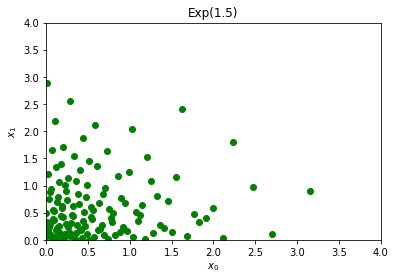

In [4]:
# 2 dimension
exponential_measure = InverseCDFSampling(
    distribution_mimicking_uniform = Sobol(dimension=2,seed=7),
    inverse_cdf_fun = exp_inverse_cdf)
exp_samples = exponential_measure.gen_samples(2**7)
pyplot.scatter(exp_samples[:,0],exp_samples[:,1],color='g')
pyplot.xlabel('$x_0$')
pyplot.ylabel('$x_1$')
pyplot.xlim([0,4])
pyplot.ylim([0,4])
pyplot.title('Exp(1.5)');

## Cauchy
$$y \sim cauchy(x_0,\gamma) \qquad \text{pdf y } f(x) = [\pi \gamma (1+(\frac{x-x_0}{\gamma})^2)]^{-1} \\
\text{cdf y } F(x) = \frac{1}{\pi} arctan(\frac{x-x_0}{\gamma}) + 1/2 \qquad \\
\text{inverse cdf } F^{-1}(x) = tan(\pi(x-\frac{1}{2}))\gamma + x_0 \\
\therefore y \sim  tan(\pi(u-\frac{1}{2}))\gamma + x_0 \text{ for } u \sim U_d(0,1)$$

In [5]:
# constants
x0 = -2
gamma = .75
cauchy_pdf = lambda x,x0=x0,gamma=gamma: (pi*gamma*(1+((x-x0)/gamma)**2))**(-1)
cauchy_inverse_cdf = lambda u,x0=x0,gamma=gamma: tan(pi*(u-.5))*gamma+x0

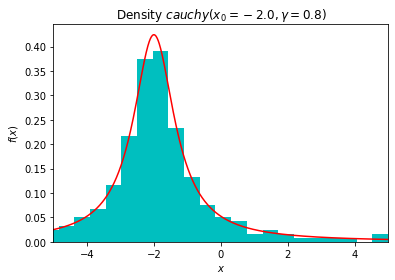

In [6]:
# 1 dimension
distribution = Sobol(dimension=1)
cauchy_measure = InverseCDFSampling(
    distribution_mimicking_uniform = Sobol(dimension=1,seed=7),
    inverse_cdf_fun = cauchy_inverse_cdf)
cauchy_samples = cauchy_measure.gen_samples(2**8)
# samples plot
pyplot.hist(cauchy_samples,bins='auto',density=True,color='c')
# curve plot
pts = arange(-5,5,.01)
pyplot.plot(pts,cauchy_pdf(pts),color='r')
# plot metas
pyplot.xlim([-5,5])
pyplot.xlabel('$x$')
pyplot.ylabel('$f(x)$')
pyplot.title('Density $cauchy(x_0=%.1f,\gamma=%.1f)$'%(x0,gamma));

## Acceptance Rejection Sampling

$$\text{objective pdf } f(x) = \begin{cases}
        16x/3 &, 0 \leq x \leq 1/4,\\
        4/3 &, 1/4 <x < 3/4,\\
        16(1-x)/3 &, 3/4 < x < 1
\end{cases}$$

In [7]:
def f(x):
    x = x if x<.5 else 1-x # utilize symmetry 
    density = 16.*x/3. if x<1./4 else 4./3
    return density

Expected (total draws / successful draws) = c = 1.467
Successful Draws: 5000  Total Draws: 7299


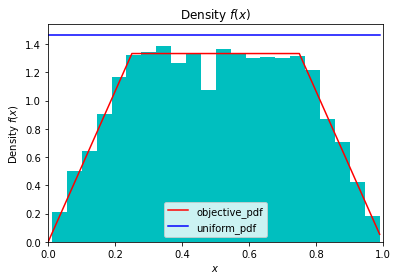

In [8]:
sampling_measure = Uniform(IIDStdUniform(1,seed=7))
distribution = AcceptanceRejectionSampling(
    objective_pdf = f,
    measure_to_sample_from = sampling_measure)
samples = distribution.gen_samples(5000)
print('Expected (total draws / successful draws) = c = %.3f'%distribution.c)
print('Successful Draws: %-5d Total Draws: %d'%(distribution.successful_draws,distribution.total_draws))
# samples plot
pyplot.hist(samples,bins='auto',density=True,color='c')
# curve plots
pts = arange(0,1,.01)
pyplot.plot(pts,list(map(f,pts)),color='r',label='objective_pdf')
gaussian_curve = distribution.c*array([sampling_measure.pdf(x) for x in pts]).flatten()
pyplot.plot(pts,gaussian_curve,color='b',label='uniform_pdf')
# plot metas
pyplot.legend()
pyplot.xlim([0,1])
pyplot.xlabel('$x$')
pyplot.ylabel('Density $f(x)$')
pyplot.title('Density $f(x)$');

## Bayesian Example 
Taken from Bayesian Data Analysis. 3rd Edition. Andrew Gelman, John B. Carlin, Hal S. Stern, David B. Dunson, Aki Vehtari, Donald B. Rubin.
Chapter 10 Section 9 (Exercises) Problem 5

$y_j \sim Binomial(n_j,\theta_j) \qquad \theta_j = {logit}^{-1}(\alpha+\beta x_j) \qquad x_j \sim U(0,1) \qquad j=1,...10$

$n_j \sim Poisson^{+}(5)$ where $Poisson^{+}$ is the Poisson distribution restricted to positive values

Independent priors $\alpha \sim t_4(0,2^2)$ and $\beta \sim t_4(0,1)$

In [9]:
# Sample a dataset
random.seed(7)
sigmoid = lambda x: 1/(1+exp(-x)) # inverse logit
j = 10
prior_alpha = stats.t.rvs(df=4,loc=0,scale=2,size=j)
prior_beta = stats.t.rvs(df=4,loc=0,scale=1,size=j)
x = stats.uniform.rvs(loc=0,scale=1,size=j)
n = stats.poisson.rvs(mu=5,size=j)
if (n==0).any(): raise Exception('all n must be positive')
theta = sigmoid(prior_alpha+prior_beta*x)
y = stats.binom.rvs(n=n,p=theta,size=j)
def posterior_density(params): # proportaional to p(alpha,beta|y) --> distribution.c is NOT interpretable
    alpha,beta = params
    prior_dens = stats.t.pdf(alpha,df=4,loc=0,scale=2)*stats.t.pdf(beta,df=4,loc=0,scale=1)
    theta = sigmoid(alpha+beta*x)
    sampling_dens = prod(theta**y * (1-theta)**(n-y))
    posterior_dens = prior_dens*sampling_dens
    return posterior_dens

In [10]:
# Naive sampling_measure
sampling_measure = Gaussian(IIDStdGaussian(2,seed=7),mean=[0,0],covariance=[[2,0],[0,1]])
distribution = AcceptanceRejectionSampling(posterior_density,sampling_measure)
samples = distribution.gen_samples(100)
pd_mean_estimate = samples.mean(0)
pd_cov_estimate = cov(samples.T)
print('Successful Draws: %-5d Total Draws: %d'%(distribution.successful_draws,distribution.total_draws))
print('Posterior samples mean\n%s'%str(pd_mean_estimate))
print('Posterior samples covariance\n%s'%str(pd_cov_estimate))

Successful Draws: 100   Total Draws: 2010
Posterior samples mean
[ 1.236 -0.254]
Posterior samples covariance
[[ 0.327 -0.345]
 [-0.345  0.522]]


In [11]:
# More Efficient sampling_measure using estimate of posterior mean and covariance
sampling_measure = Gaussian(IIDStdGaussian(2,seed=7),mean=pd_mean_estimate,covariance=pd_cov_estimate)
distribution = AcceptanceRejectionSampling(posterior_density,sampling_measure)
samples = distribution.gen_samples(1000)
print('Successful Draws: %-5d Total Draws: %d'%(distribution.successful_draws,distribution.total_draws))
print('95%% confidence interval for alpha: (%.3f,%.3f)'%tuple(quantile(samples[:,0],[.025,.975])))
print('95%% confidence interval for beta:  (%.3f,%.3f)'%tuple(quantile(samples[:,1],[.025,.975])))

Successful Draws: 1000  Total Draws: 3596
95% confidence interval for alpha: (0.187,2.533)
95% confidence interval for beta:  (-1.807,1.165)


## Importance Sampling
Let $\mathcal{X}$ be the domain. We are interested in integrand $g(\mathbf{x})$ defined with respect to measure $\rho(\mathbf{x})$ for $\mathbf{x} \in \mathcal{X}$. 
$$\int_{\mathcal{X}} g(\mathbf{x}) \rho(\mathbf{x})d\mathbf{x}.$$ 

For importance sampling, we can capture this domain, $\mathcal{X}$, in a unit box, $\beta=[a,b]^d$, such that

$$\forall \mathbf{x} \in \mathcal{X}: \mathbf{x} \in \beta \\
\tilde{g}(\mathbf{x}) = \begin{cases} g(\mathbf{x}), & \mathbf{x} \in \mathcal{X} \\ 0, & \text{otherwise} \end{cases} \qquad \text{for } \mathbf{x} \in \beta \\
\tilde{\rho}(\mathbf{x}) = \begin{cases} \rho(\mathbf{x}), & \mathbf{x} \in \mathcal{X} \\ 0, & \text{otherwise} \end{cases} \qquad \text{for } \mathbf{x} \in \beta \\
\therefore \int_{\mathcal{X}} g(\mathbf{x}) \rho(\mathbf{x})dx = \int_{\beta} \tilde{g}(\mathbf{x}) \tilde{\rho}(\mathbf{x}) d\mathbf{x}$$

### Quarter Circle Example
Let the domain be the quarter unit circle in the first quadrant $\mathcal{X} = \{\mathbf{x} : \mathbf{x}_1^2+\mathbf{x}_2^2 < 1, \mathbf{x}_1\geq 0, \mathbf{x}_2\geq0\}$, the integrand $g(\mathbf{x}) = \mathbf{x}_1+\mathbf{x}_2$, and our measure $\rho(x) = 4/\pi$. Therefore we choose $\beta = [0,1]^2$ and solve

$$\int_{\mathcal{X}} g(\mathbf{x}) \rho(\mathbf{x})dx = \int_0^1 \int_0^1 \tilde{g}(\mathbf{x}) \tilde{\rho}(\mathbf{x}) d\mathbf{x}_1d\mathbf{x}_2 = \frac{8}{3\pi}$$

In [12]:
true_value = 8/(3*pi)
abs_tol = .001
def quarter_circle_uniform_pdf(x):
    x1,x2 = x
    if sqrt(x1**2+x2**2)<1 and x1>=0 and x2>=0:
        return 4./pi # 1/(pi*(1**2)/4)
    else:
        return 0. # outside of quarter circle

In [13]:
measure = ImportanceSampling(
    objective_pdf = quarter_circle_uniform_pdf,
    measure_to_sample_from = Uniform(Lattice(dimension=2,seed=9)))
integrand = CustomFun(measure, lambda x: x.sum(1))
solution,data = CubQMCLatticeG(integrand,abs_tol=abs_tol).integrate()
print(data)
within_tol = abs(solution-true_value)<abs_tol
print('Within tolerance of true value %.3f: %s'%(true_value,within_tol))

Solution: 0.8494         
CustomFun (Integrand Object)
Lattice (DiscreteDistribution Object)
    dimension       2^(1)
    randomize       1
    order           natural
    seed            9
    mimics          StdUniform
ImportanceSampling (TrueMeasure Object)
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         0.001
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
LDTransformData (AccumulateData Object)
    n_total         2^(14)
    solution        0.849
    error_bound     5.14e-04
    time_integrate  0.247
Within tolerance of true value 0.849: True
